C:\Users\test\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


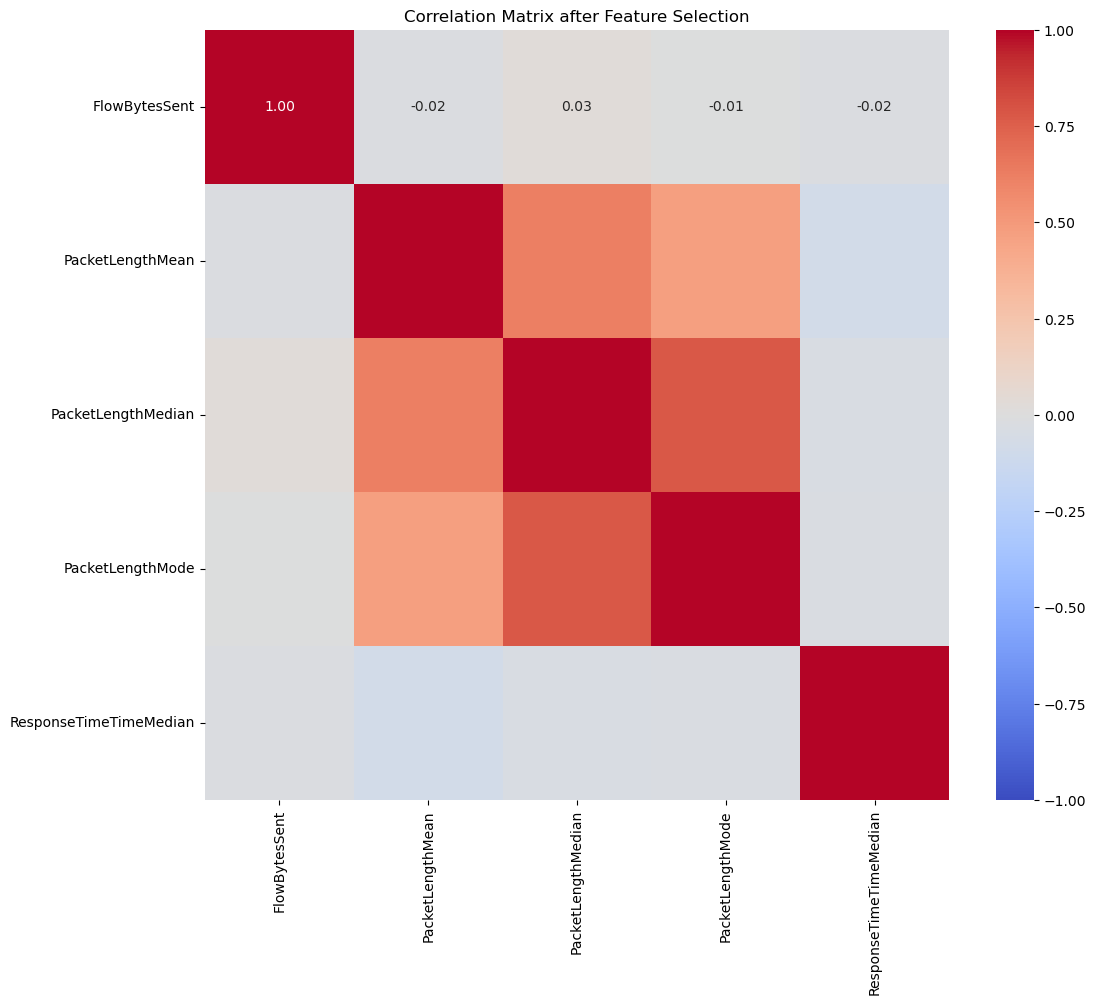

Cross-validation Accuracy Scores: [0.99618725 0.99604267 0.99638003 0.99645498 0.99614975]
Mean Accuracy: 0.9962429368912517
Classification Report:
              precision    recall  f1-score   support

         DoH       1.00      0.99      0.99     53863
      NonDoH       1.00      1.00      1.00    179565

    accuracy                           1.00    233428
   macro avg       1.00      0.99      0.99    233428
weighted avg       1.00      1.00      1.00    233428

Accuracy Score: 0.9964057439553096


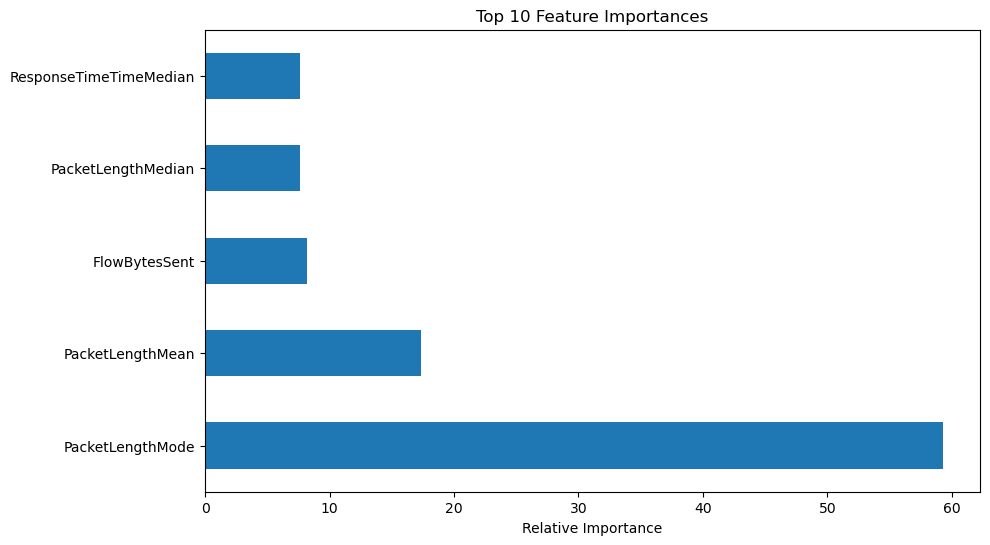

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Load datasets
dataset1 = pd.read_csv('l1-doh.csv')
dataset2 = pd.read_csv('l1-nondoh.csv')

# Ignore specified columns
ignore_columns = ['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp']
dataset1 = dataset1.drop(columns=ignore_columns)
dataset2 = dataset2.drop(columns=ignore_columns)

# Combine datasets and encode labels
combined_data = pd.concat([dataset1, dataset2], ignore_index=True)
X = combined_data.drop(columns=['Label'])
y = combined_data['Label']

# Encode the categorical label
le = LabelEncoder()
y = le.fit_transform(y)

# Feature selection using CatBoost's feature importance
model = CatBoostClassifier(random_state=42, verbose=False)
model.fit(X, y)

# Select features using feature importance
selector = SelectFromModel(model, prefit=True)
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]

# Correlation matrix after feature selection
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
corr_matrix = X_selected_df.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix after Feature Selection')
plt.show()

# Remove highly correlated features (optional)
# Code to remove highly correlated features if needed

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize CatBoost classifier
model = CatBoostClassifier(random_state=42, verbose=False)

# Evaluate using cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')

print(f'Cross-validation Accuracy Scores: {scores}')
print(f'Mean Accuracy: {np.mean(scores)}')

# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Classification report and accuracy score
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')

# Feature selection graph
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(model.feature_importances_, index=selected_features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Relative Importance')
plt.show()
